In [1]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import os
from ECG_classifier import Classifier

encoding = 'NAVR'
freq = [0]*len(encoding)

N_counter = 0

class NSTDB(torch.utils.data.Dataset):
    def __init__(self):
        global N_counter
        self.h5_list = []
        for root, dirs, files in os.walk('../segmentation'):
            for f in files:
                path = os.path.join(root, f)
                if path[-2:] != 'h5':
                    continue
                with h5py.File(path, 'r') as h5:
                    if h5['MLII'][:].size != 252:
                        continue
                    freq[encoding.index(h5['label'][()])] += 1
                self.h5_list.append(os.path.join(root, f))
        
    def __getitem__(self, index):
        with h5py.File(self.h5_list[index], 'r') as f:
            index = f['index'][()]
            MLII = torch.unsqueeze(torch.tensor(f['MLII'][:]), 0)
            label = torch.tensor(encoding.index(f['label'][()]))
            return {
                'index': index,
                'MLII': MLII.float(),
                'label': label,
            }
    def __len__(self):
        return len(self.h5_list)
dataset = NSTDB()

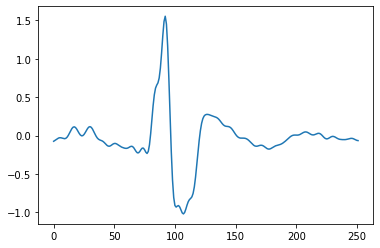

Label: tensor(3)
Length: 4264
freq: [1543, 96, 460, 2165]
Weight tensor([ 1.4031, 22.5521,  4.7065,  1.0000])


In [2]:
import matplotlib.pyplot as plt
index, MLII, label = dataset[100].values()
plt.plot(range(len(MLII[0])), MLII[0])
plt.show()
print('Label:', label)
print('Length:', len(dataset))
print('freq:', freq)
weight = max(freq)/torch.tensor(freq)
print('Weight', weight)

In [3]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(0.9*len(dataset)), len(dataset)-int(0.9*len(dataset))])
print(len(dataset_train), len(dataset_val))
from torch.utils.data import DataLoader
BATCH_SIZE = 512
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

3837 427


In [4]:
model = Classifier().cuda()

In [5]:
criterion = nn.CrossEntropyLoss(weight=weight).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [6]:
def train(input_data, model, criterion, optimizer):
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for data in input_data:
        index, MLII, label = data['index'], data['MLII'].cuda(), data['label'].cuda()
        
        optimizer.zero_grad()
        out = model(MLII)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(out, 1)
        total_count += label.shape[0]
        acc_count += (pred == label).sum().item()
        loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [7]:
def val(input_data, model, criterion):
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            index, MLII, label = data['index'], data['MLII'].cuda(), data['label'].cuda()
        
            out = model(MLII)
            loss = criterion(out, label)

            _, pred = torch.max(out, 1)
            total_count += label.shape[0]
            acc_count += (pred == label).sum().item()
            loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [8]:
max_epochs = 20
log_interval = 1

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

min_loss = 1000000
best_model = None

print("Start training...")
for epoch in range(1, max_epochs+1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
        
    if epoch % log_interval == 0:
        print('')
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
        
torch.save(best_model, 'ECG_classifier_params.pth')

Start training...

==================== Epoch 1 ====================
Train Acc: 0.474329 Train Loss: 1.351076
  Val Acc: 0.948478   Val Loss: 1.239099

==================== Epoch 2 ====================
Train Acc: 0.963513 Train Loss: 1.142059
  Val Acc: 0.967213   Val Loss: 1.017024

==================== Epoch 3 ====================
Train Acc: 0.964816 Train Loss: 0.924986
  Val Acc: 0.967213   Val Loss: 0.817020

==================== Epoch 4 ====================
Train Acc: 0.963253 Train Loss: 0.748841
  Val Acc: 0.971897   Val Loss: 0.656065

==================== Epoch 5 ====================
Train Acc: 0.959083 Train Loss: 0.615815
  Val Acc: 0.969555   Val Loss: 0.549327

==================== Epoch 6 ====================
Train Acc: 0.955695 Train Loss: 0.525828
  Val Acc: 0.967213   Val Loss: 0.482088

==================== Epoch 7 ====================
Train Acc: 0.951525 Train Loss: 0.465670
  Val Acc: 0.962529   Val Loss: 0.438896

==================== Epoch 8 ====================


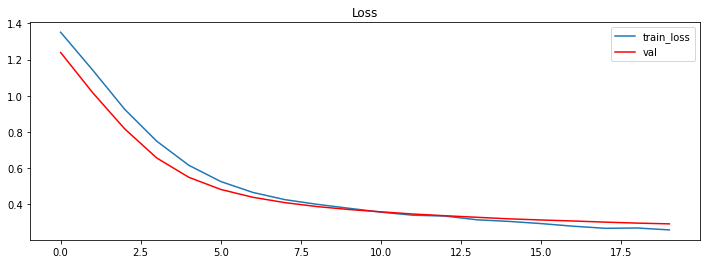

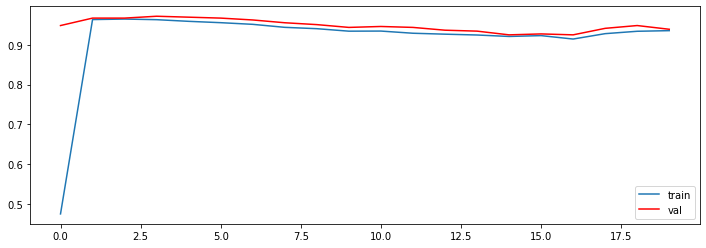

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train_loss', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.show()